<a href="https://colab.research.google.com/github/Saigirish-Suryadevara/Saigirish_INFO5731_Fall2024/blob/main/Saigirish_Suryadevara_INFO5731_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
# Write your code here
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf

# loading the dataset and preprocessing
def data_loading(path):
  texts, labels =[],[]
  with open(path,'r') as file:
    for l in file:
      label, text = l[0], l[2:].strip()
      texts.append(text)
      labels.append(int(label))
    return texts, labels

# loading test and training datsets
texts_train,labels_train = data_loading("/content/stsa-train.txt")
texts_test, labels_test = data_loading("/content/stsa-test.txt")

#splitting training dataset into validation sets
texts_train, texts_val, labels_train, labels_val = train_test_split(
    texts_train, labels_train, test_size = 0.2, random_state = 42)

# Vectorisation of text
vectorize = CountVectorizer()
features_train = vectorize.fit_transform(texts_train)
features_val = vectorize.transform(texts_val)
features_test = vectorize.transform(texts_test)

result = {}

# defining function to evaluate,train & fetch results
def model_eval(model, model_name):
  scores = cross_val_score(model, features_train, labels_train, cv = 10)
  print(f"{model_name} Cross-Validation scores:{np.mean(scores)}")

  # training and evaluating on validation dataset
  model.fit(features_train, labels_train)
  predictions_val = model.predict(features_val)

  # metrics calcuation
  acc = accuracy_score(labels_val,predictions_val)
  prec = precision_score(labels_val,predictions_val)
  rec = recall_score(labels_val,predictions_val)
  f1 = f1_score(labels_val,predictions_val)

  # fetching results
  result[model_name] = {
      "accuracy":acc,
      "precision":prec,
      "recall":rec,
      "f1_score":f1
  }
  print(f"{model_name} Results of Validation:\n", classification_report(labels_val,predictions_val))

# evaluating each model
model_eval(MultinomialNB(),"MultinomialNB")
model_eval(SVC(),"SVM")
model_eval(KNeighborsClassifier(),"KNN")
model_eval(DecisionTreeClassifier(),"Decision Tree")
model_eval(RandomForestClassifier(), "Random Forest")
model_eval(XGBClassifier(), "XGBoost")

# Bert model
def bert_model_eval():
  tokeniser = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
  model_bert = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

  #tokenising data and converting into Tensorflow inouts
  encodings_train = tokeniser(texts_train, truncation = True, padding = True, max_length = 128, return_tensors = "tf")
  encodings_val = tokeniser(texts_val, truncation = True, padding = True, max_length = 128, return_tensors = "tf")
  encodings_test = tokeniser(texts_test, truncation = True, padding = True, max_length = 128, return_tensors = "tf")

  tf_labels_train = tf.convert_to_tensor(labels_train, dtype=tf.int32)
  tf_labels_val = tf.convert_to_tensor(labels_val, dtype=tf.int32)

  #compiling Bert model for training
  model_bert.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
      metrics = ['accuracy']
  )

  # training model on training data
  model_bert.fit(
      dict(encodings_train),
      tf_labels_train,
      validation_data = (dict(encodings_val), tf_labels_val),
      epochs = 3,
      batch_size = 64
  )

  predictions_val = model_bert.predict(dict(encodings_val)).logits
  predictions_val = np.argmax(predictions_val, axis = 1)

  # priting classification report
  print("BERT validation results:\n", classification_report(labels_val, predictions_val))

  # Calculating & storing results in result dictionary
  bert_acc = accuracy_score(labels_val, predictions_val)
  bert_prec = precision_score(labels_val, predictions_val)
  bert_recall = recall_score(labels_val, predictions_val)
  bert_f1 = f1_score(labels_val, predictions_val)

  result["BERT"] = {
      "accuracy": bert_acc,
      "precision": bert_prec,
      "recall": bert_recall,
      "f1_score": bert_f1

  }

bert_model_eval()

# Final evaluating on test set with best model
model_best = RandomForestClassifier()
model_best.fit(features_train, labels_train)
predictions_test = model_best.predict(features_test)

print("Final test results:\n", classification_report(labels_test, predictions_test))

#printing results for each model
for model_name, metrics in result.items():
  print(f"\n{model_name} Results:")
  for m,v in metrics.items():
    print(f"{m.capitalize()}: {v:.4f}")





MultinomialNB Cross-Validation scores:0.7805263054817504
MultinomialNB Results of Validation:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       671
           1       0.78      0.84      0.81       713

    accuracy                           0.79      1384
   macro avg       0.80      0.79      0.79      1384
weighted avg       0.80      0.79      0.79      1384

SVM Cross-Validation scores:0.7353712275021055
SVM Results of Validation:
               precision    recall  f1-score   support

           0       0.78      0.70      0.73       671
           1       0.74      0.81      0.77       713

    accuracy                           0.76      1384
   macro avg       0.76      0.75      0.75      1384
weighted avg       0.76      0.76      0.75      1384

KNN Cross-Validation scores:0.5682773973273447
KNN Results of Validation:
               precision    recall  f1-score   support

           0       0.61      0.58      0.60   

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
87/87 [==============================] - 63s 550ms/step - loss: 0.4415 - accuracy: 0.7946 - val_loss: 0.2704 - val_accuracy: 0.8945
Epoch 2/3
87/87 [==============================] - 45s 514ms/step - loss: 0.2304 - accuracy: 0.9174 - val_loss: 0.2518 - val_accuracy: 0.9025
Epoch 3/3
44/44 [==============================] - 6s 85ms/step
BERT validation results:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       671
           1       0.91      0.89      0.90       713

    accuracy                           0.90      1384
   macro avg       0.90      0.90      0.90      1384
weighted avg       0.90      0.90      0.90      1384

Final test results:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72       912
           1       0.71      0.78      0.74       909

    accuracy                           0.73      1821
   macro avg       0.73      0.73      0.73      1821
weight

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

K-Means clustering score: 0.03412221685033908
DBSCAN clustering score: -0.0017992676881492383
Hierarchial clustering score: 0.018003729695297763
word2vec K-Means clustering score: 0.3443298137478952
Bert K-Means clustering score: 0.08070048


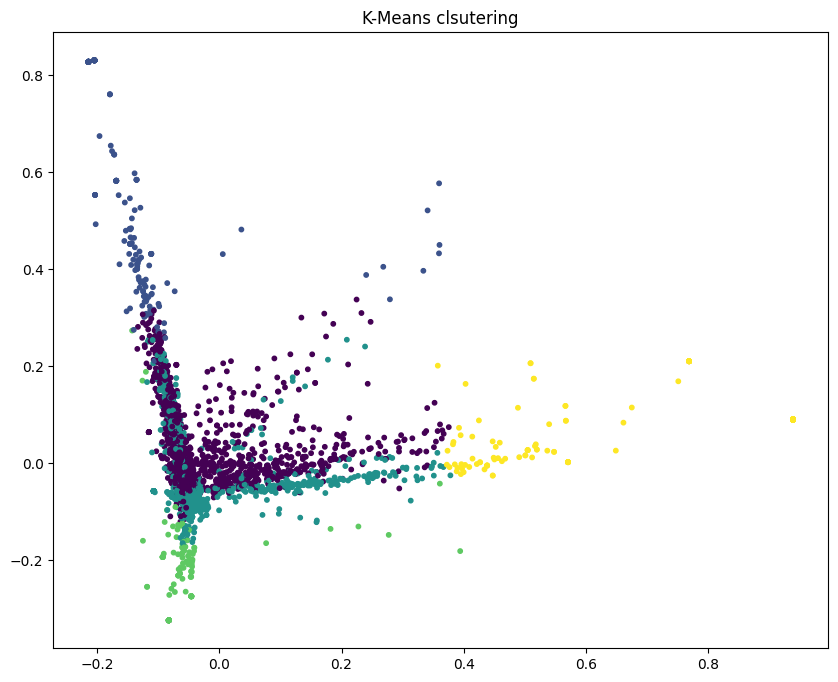

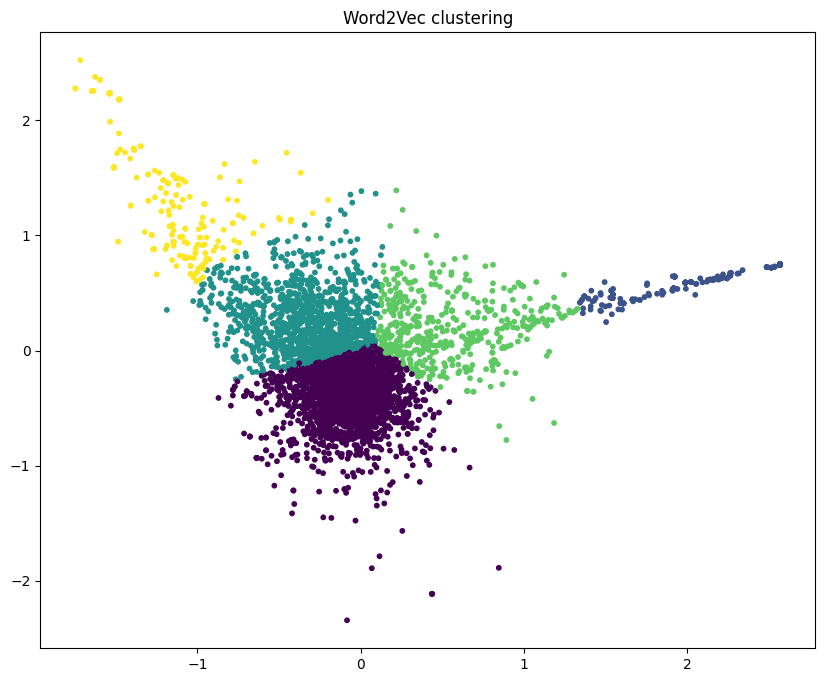

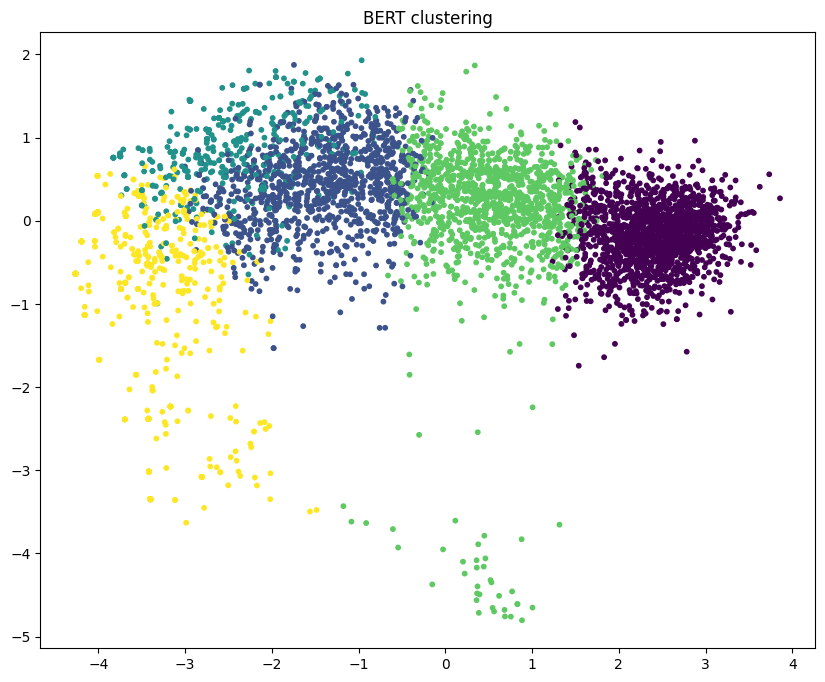

In [5]:
# Write your code here
import pandas as pd
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from transformers import DistilBertTokenizer, DistilBertModel
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# laoding the dataset
path_file = '/content/Amazon_Unlocked_Mobile.csv'
df_data = pd.read_csv(path_file, on_bad_lines = 'skip')

# data preprocessing and taking a subset for faster execution
df_data = df_data.dropna(subset=['Reviews'])
df_data = df_data.sample(n=5000, random_state= 42)
data_text = df_data['Reviews'].astype(str).tolist()

# Tfidf vectorisation
tfidf_vector = TfidfVectorizer(max_features = 5000, stop_words='english')
matrix_tfidf = tfidf_vector.fit_transform(data_text)

# K-means clustering
k_mean = KMeans(n_clusters=5, random_state=42)
labels_kmean = k_mean.fit_predict(matrix_tfidf)

print("K-Means clustering score:", silhouette_score(matrix_tfidf,labels_kmean))

# DBSCAN Clustering
db_scan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
labels_dbscan = db_scan.fit_predict(matrix_tfidf)

print("DBSCAN clustering score:", silhouette_score(matrix_tfidf,labels_dbscan) if len(set(labels_dbscan))>1 else "N/A")

# Hierarchial clustering
dense_tfidf = matrix_tfidf.toarray()
no_zero_row = dense_tfidf[~(dense_tfidf==0).all(axis=1)]
hier_clust = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='average')
labels_hier = hier_clust.fit_predict(no_zero_row)

print("Hierarchial clustering score:", silhouette_score(no_zero_row,labels_hier))

# word2vec clustering
data_tokenized = [r.split() for r in data_text]
model_word2vec = Word2Vec(sentences=data_tokenized, vector_size=100)
vector_word2vec = np.array([np.mean([model_word2vec.wv[w] for w in words if w in model_word2vec.wv] or [np.zeros(100)], axis = 0) for words in data_tokenized])

word2vec_kmean = KMeans(n_clusters=5, random_state=42)
labels_word2vec = word2vec_kmean.fit_predict(vector_word2vec)

print("word2vec K-Means clustering score:", silhouette_score(vector_word2vec,labels_word2vec))

# Bert clustering
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model_bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

def encode_bert(texts,tokenizer,model,max_len=50):
  encd = tokenizer.batch_encode_plus(texts, max_length= max_len, padding = True, truncation = True, return_tensors = "pt")
  with torch.no_grad():
    output_model = model(**encd)
  return output_model.last_hidden_state.mean(dim=1).numpy()

vectors_bert = encode_bert(data_text, tokenizer, model_bert)

bert_kmean = KMeans(n_clusters=5, random_state=42)
labels_bert = bert_kmean.fit_predict(vectors_bert)

print("Bert K-Means clustering score:", silhouette_score(vectors_bert,labels_bert))

# visulaisation of clusters
def cluster_visual(vectors, labels, title):
  pca = PCA(n_components=2)
  data_reduced = pca.fit_transform(vectors)
  plt.figure(figsize=(10,8))
  plt.scatter(data_reduced[:, 0], data_reduced[:,1], c=labels, cmap='viridis', s=10)
  plt.title(title)
  plt.show()

cluster_visual(matrix_tfidf.toarray(), labels_kmean, "K-Means clsutering")
cluster_visual(vector_word2vec, labels_word2vec, "Word2Vec clustering")
cluster_visual(vectors_bert, labels_bert, "BERT clustering")










**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.The results of clustering algortihms vary due to thier different approaches. K-means performed adequately for spherical clustering but had issues with noise data.DBSCAN exposed strength in iutlier detection & arbitrary cluster recognition. Hierarchial clustering produced accurate relations but is drianing for large sample sizes.word2vec performed better due to semantic links which improved quality clusters. BERT was superior to other sue to contextual embeddings, which gave more coherent clusters, but at a cost of long runtimes.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
This assignemnt provided great hands-on experience in applying diverse clustering methods & text classification algorithms.
Working with models like word2vec & bert exposed the power of contextual and semantic embeddings.
But using colab which usual doesnt use gpu for runtime made it quite long & diffciult to execute the program.
This assignemment provided me a good challenging task.






'''